## Forecasting with FB Prophet

### Import Packages

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

### Import Data

In [15]:
df = pd.read_csv('../data/interim/fifteen_minute_data.csv', index_col = 0, parse_dates = True)

In [16]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

### Forecast 15-minute Data

This is our filled energy output.  One thing we'd like to do is see if we can forecast in 15-minute intervals since it seems that our H-W models and our Sarima models do not do that well.  Let's just take a two week slice of the data and see how Prophet does.  

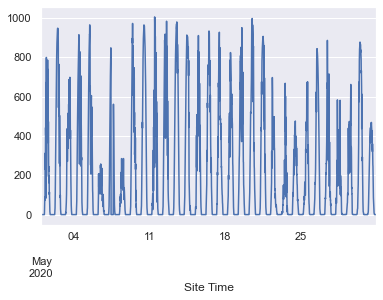

In [18]:
df['Shark Meter, KWtotal Kilowatts'].loc['2020-05'].plot();

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


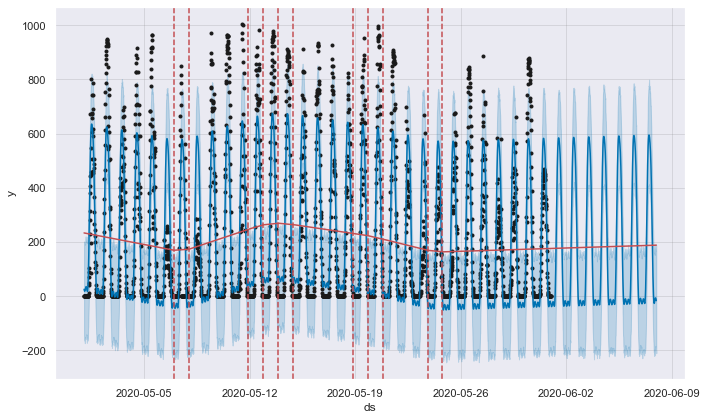

In [19]:
# Our dataframe must have columns 'ds' and 'y'
power_May2020 = df.loc['2020-05'].copy()
power_May2020['y'] = power_May2020['Shark Meter, KWtotal Kilowatts']
power_May2020['ds'] = power_May2020.index

prophet = Prophet(daily_seasonality = True, weekly_seasonality=False)
prophet.fit(power_May2020)
future = prophet.make_future_dataframe(periods=4*24*7, freq='15T')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

Note: I have tried tuning seasonality_prior_scale to see if we can model the daily seasonality with larger fluctuations but this did not make a difference visually.  

The original data is the black dots, the forecast line is in blue, and the confidence levels are in light blue.  We can see that Prophet is doing quite well with this forecast.  Much better than H-W or SARIMA.  Note that sometimes it does predict negative energy output but we are unable to configure a minimum.  

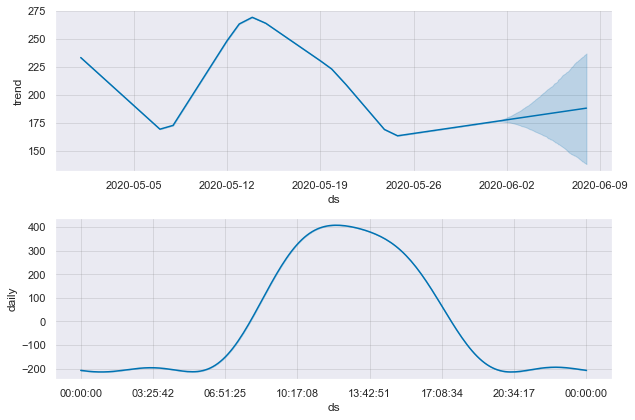

In [20]:
fig2 = prophet.plot_components(forecast)

Since we have data for our forecasted period, we can calculate our errors on test data for this model.  

In [21]:
print('RMSE:', np.sqrt(mean_squared_error(df['Shark Meter, KWtotal Kilowatts'].loc['2020-06-01':'2020-06-07'], \
                                          forecast['yhat'].iloc[-672:])))
print('MSE:', mean_absolute_error(df['Shark Meter, KWtotal Kilowatts'].loc['2020-06-01':'2020-06-07'], \
                                          forecast['yhat'].iloc[-672:]))

RMSE: 131.26637946658306
MSE: 84.90551159943914


Let's try modeling entire time period and forecasting one year into the future just for kicks.  

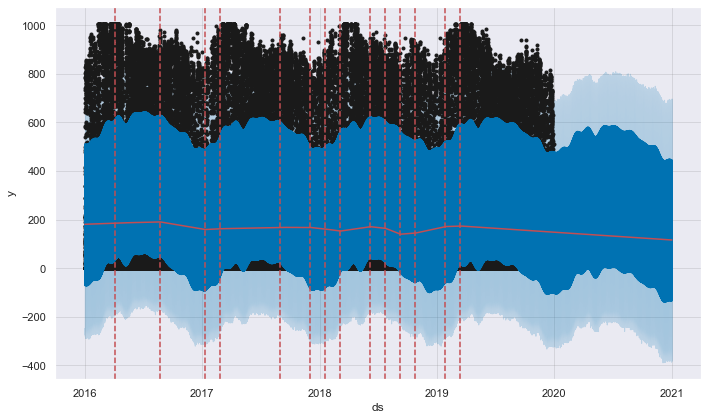

In [22]:
# Our dataframe must have columns 'ds' and 'y'
power = df.loc['2016':'2019'].copy()
power['y'] = power['Shark Meter, KWtotal Kilowatts']
power['ds'] = power.index

prophet = Prophet(daily_seasonality = True, yearly_seasonality=True, weekly_seasonality=False)
prophet.fit(power)
future = prophet.make_future_dataframe(periods=4*24*366, freq='15T')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

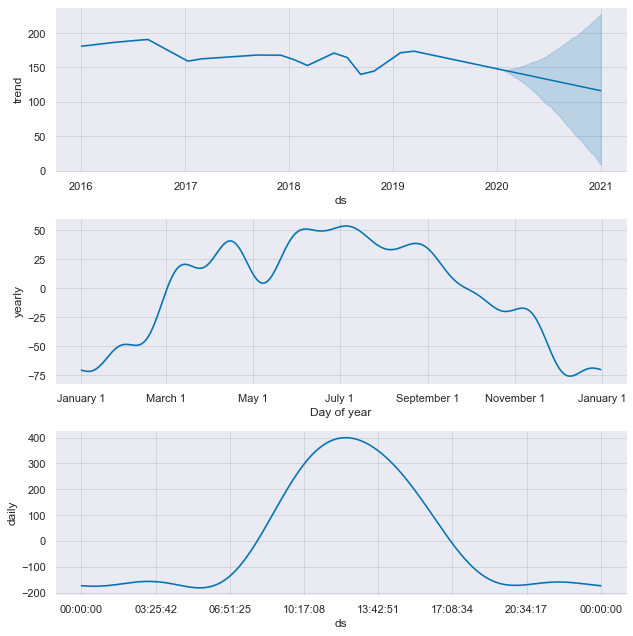

In [23]:
fig2 = prophet.plot_components(forecast)

In [24]:
print('RMSE:', np.sqrt(mean_squared_error(df['Shark Meter, KWtotal Kilowatts'].loc['2020'], \
                                          forecast['yhat'].iloc[-4*24*366:])))
print('MSE:', mean_absolute_error(df['Shark Meter, KWtotal Kilowatts'].loc['2020'], \
                                          forecast['yhat'].iloc[-4*24*366:]))

RMSE: 156.40327006953459
MSE: 106.8079137596598


### Forecast Daily Data

Let's get prediction of the trend.  To that end, let's look at energy, and we're going to resample to a daily frequency and then predict a trend over the next six years.  

In [79]:
# First we need to get hourly energy in KWH
energy_hourly = df[['Shark Meter, KWtotal Kilowatts']].resample('H').sum()*.25
energy_hourly.columns=['Shark Meter, KWH']

# Then we need to get daily energy in KHW
energy_daily = energy_hourly.resample('D').sum()

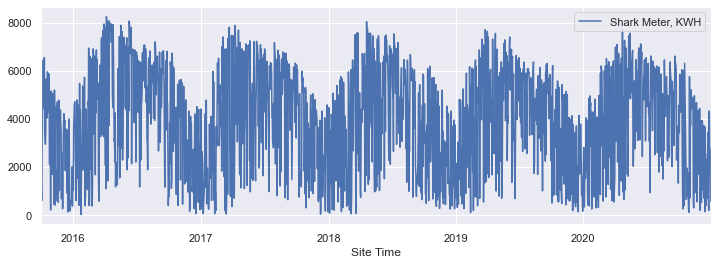

In [80]:
energy_daily.plot(figsize=(12,4));

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


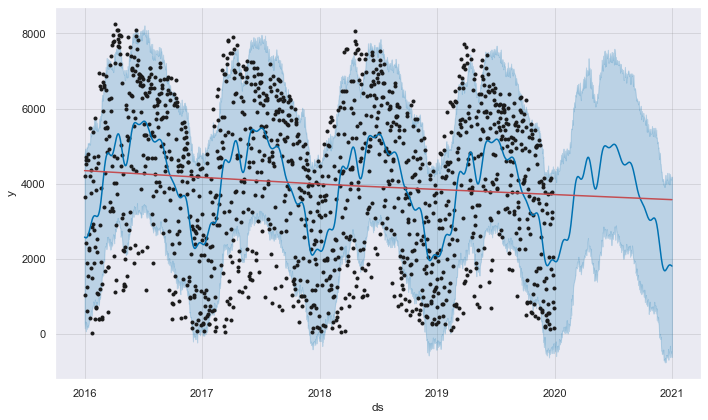

In [81]:
# Our dataframe must have columns 'ds' and 'y'
energy_df = energy_daily.loc['2016':'2019'].copy()
energy_df['y'] = energy_df['Shark Meter, KWH']
energy_df['ds'] = energy_df.index

prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False)
prophet.fit(energy_df)
future = prophet.make_future_dataframe(periods=366, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

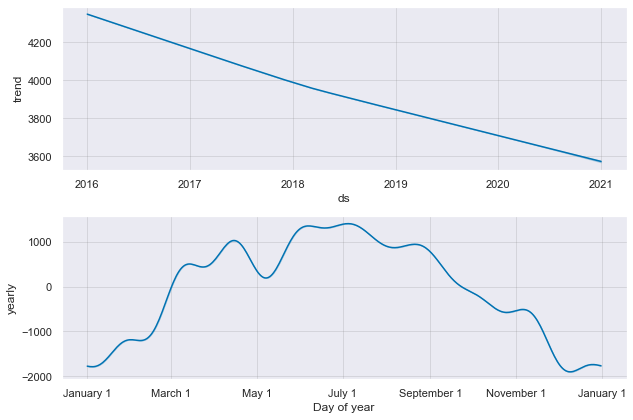

In [82]:
fig2 = prophet.plot_components(forecast)
plt.show()

This shows a pretty strong downward trend in energy production.  

In [35]:
print('RMSE:', np.sqrt(mean_squared_error(energy_daily['Shark Meter, KWH'].loc['2020'], \
                                            forecast['yhat'].iloc[-366:])))
print('MSE:', mean_absolute_error(energy_daily['Shark Meter, KWH'].loc['2020'], \
                                          forecast['yhat'].iloc[-366:]))

RMSE: 1750.1917302065092
MSE: 1506.4910950025126


### Add Hyperparameter Tuning and Cross-Validation

In [73]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality': [True],
    'weekly_seasonality': [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    prophet = Prophet(**params).fit(energy_df)  # Fit model with given params
    df_cv = cross_validation(prophet, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 9 forecasts with cutoffs between 2017-07-14 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x128251280>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 9 forecasts with cutoffs between 2017-07-14 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1240f2280>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 9 forecasts with cutoffs between 2017-07-14 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1256fa670>
INFO:fbprophet:Disabling daily seasonality. Run prophet with 

    changepoint_prior_scale  seasonality_prior_scale  yearly_seasonality  \
0                     0.001                     0.01                True   
1                     0.001                     0.10                True   
2                     0.001                     1.00                True   
3                     0.001                    10.00                True   
4                     0.010                     0.01                True   
5                     0.010                     0.10                True   
6                     0.010                     1.00                True   
7                     0.010                    10.00                True   
8                     0.100                     0.01                True   
9                     0.100                     0.10                True   
10                    0.100                     1.00                True   
11                    0.100                    10.00                True   
12          

In [74]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': True, 'weekly_seasonality': False}


Build final model with those parameters

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


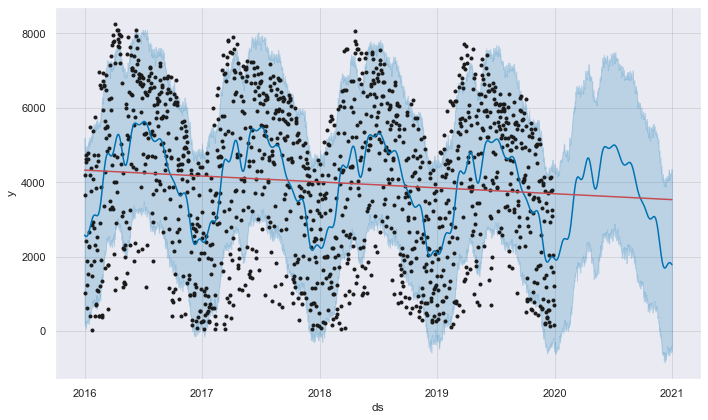

In [83]:
# Our dataframe must have columns 'ds' and 'y'
energy_df = energy_daily.loc['2016':'2019'].copy()
energy_df['y'] = energy_df['Shark Meter, KWH']
energy_df['ds'] = energy_df.index

prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.1)
prophet.fit(energy_df)
future = prophet.make_future_dataframe(periods=366, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

In [84]:
print('RMSE:', np.sqrt(mean_squared_error(energy_daily['Shark Meter, KWH'].loc['2020'], \
                                            forecast['yhat'].iloc[-366:])))
print('MSE:', mean_absolute_error(energy_daily['Shark Meter, KWH'].loc['2020'], \
                                          forecast['yhat'].iloc[-366:]))

RMSE: 1753.5861371709502
MSE: 1511.6331152409605


## Forecasting Inverter Problems

We'd like to see if we can forecast problems with the inverters.  To this end, we'll forecast the difference in the inverters if that inverter is functioning below the other inverter.  

### Convert all 15-min data to hourly

In [92]:
# First calcluate difference between two inverters
df['Difference'] = df['AE 500kW 1, AC Power Kilowatts'] - df['AE 500kW 2, AC Power Kilowatts']

# Now get hourly energy in KWH
energy_hourly = df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].resample('H').mean()
energy_hourly.columns=['AE 500kW 1, KWH','AE 500kW 2, KWH']

energy_hourly['Max Module Temp'] = df['RECx31 Weather Station, Module Temp Degrees Celsius'].resample('H').max()
energy_hourly['Max Ambient Temp'] = df['RECx31 Weather Station, Ambient Temp Degrees Celsius'].resample('H').max()
energy_hourly['Max Difference'] = df['Difference'].resample('H').max()

# Now calculate the difference between the two inverters
energy_hourly['Difference'] = energy_hourly['AE 500kW 1, KWH'] - energy_hourly['AE 500kW 2, KWH']

### Resample to Daily Data and Fill Missing Data

We're going to resample to daily data, taking the max of the hourly temps (intuitively reasoning that max temp might be the most important feature of temperature), and summing the rest.  

In [93]:
energy_daily = \
    energy_hourly[['AE 500kW 1, KWH', 'AE 500kW 2, KWH', 'Difference']].resample('D').sum()
energy_daily[['Max Module Temp','Max Ambient Temp','Max Difference']] = \
    energy_hourly[['Max Module Temp','Max Ambient Temp','Max Difference']].resample('D').max()

In [94]:
energy_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1919 entries, 2015-10-01 to 2020-12-31
Freq: D
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AE 500kW 1, KWH   1919 non-null   float64
 1   AE 500kW 2, KWH   1919 non-null   float64
 2   Difference        1919 non-null   float64
 3   Max Module Temp   1919 non-null   float64
 4   Max Ambient Temp  1919 non-null   float64
 5   Max Difference    1875 non-null   float64
dtypes: float64(6)
memory usage: 104.9 KB


In [95]:
energy_daily.fillna(0, inplace=True)

### Feature Engineering

We're going to add columns to our dataframe based on the historical data.  

In [96]:
# # Now let's have Inverter1 only see its issues and Inverter2 only see its
energy_daily['Diff_Inv1'] = energy_daily.apply(lambda x: 0 if x['Difference']>0 else -x['Difference'], axis=1)
energy_daily['Diff_Inv2'] = energy_daily.apply(lambda x: 0 if x['Difference']<0 else x['Difference'], axis=1)

energy_daily['Max_Diff_Inv1'] = energy_daily.apply(lambda x: 0 if x['Max Difference']>0 else -x['Max Difference'], axis=1)
energy_daily['Max_Diff_Inv2'] = energy_daily.apply(lambda x: 0 if x['Max Difference']<0 else x['Max Difference'], axis=1)

In [97]:
# Set up our dataframes for forecasting
Inverter1 = pd.DataFrame(energy_daily['AE 500kW 1, KWH'].copy(), columns=['AE 500kW 1, KWH'])
Inverter2 = pd.DataFrame(energy_daily['AE 500kW 2, KWH'].copy(), columns=['AE 500kW 2, KWH'])

In [98]:
# Set up our exogeneous variables. 
# These will contain information shifted by 1
#Temperatures 
Inverter1['MMT'] = energy_daily['Max Module Temp'].shift(1)
Inverter1['MAT'] = energy_daily['Max Ambient Temp'].shift(1)
Inverter2['MMT'] = energy_daily['Max Module Temp'].shift(1)
Inverter2['MAT'] = energy_daily['Max Ambient Temp'].shift(1)

# Difference between two inverters
Inverter1['Diff_Inv1'] = energy_daily['Diff_Inv1'].shift(1)
Inverter2['Diff_Inv2'] = energy_daily['Diff_Inv2'].shift(1)

# Difference between two inverters
Inverter1['Max_Diff_Inv1'] = energy_daily['Max_Diff_Inv1'].shift(1)
Inverter2['Max_Diff_Inv2'] = energy_daily['Max_Diff_Inv2'].shift(1)

In [99]:
# Drop null values from doing the shifts
Inverter1.dropna(inplace=True)
Inverter2.dropna(inplace=True)

### Forecasting

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


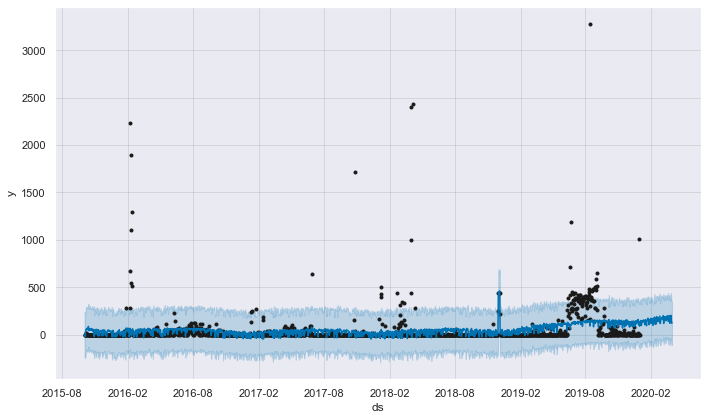

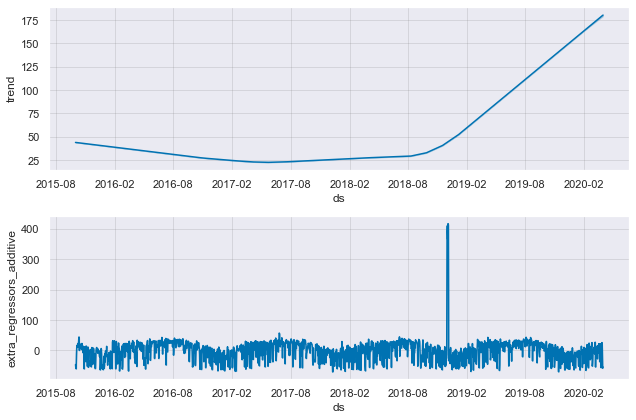

In [100]:
Inverter1['y'] = Inverter1['Diff_Inv1']
Inverter1['ds'] = Inverter1.index

prophet = Prophet(weekly_seasonality=False, yearly_seasonality=False)
prophet.add_regressor('MMT')
prophet.add_regressor('MAT')
prophet.add_regressor('Max_Diff_Inv1')
prophet.fit(Inverter1.loc[:'2019'])
future = prophet.make_future_dataframe(periods=90, freq='D')
future.set_index('ds',inplace=True)
future['MMT'] = Inverter1['MMT']
future['MAT'] = Inverter1['MAT']
future['Max_Diff_Inv1'] = Inverter1['Max_Diff_Inv1']
future.reset_index(inplace=True)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
fig2 = prophet.plot_components(forecast)

In [101]:
print('RMSE:', np.sqrt(mean_squared_error(Inverter1['Diff_Inv1'].loc['2020'], \
                                            forecast['yhat'].iloc[-366:])))
print('MSE:', mean_absolute_error(Inverter1['Diff_Inv1'].loc['2020'], \
                                          forecast['yhat'].iloc[-366:]))

RMSE: 391.9938047836018
MSE: 191.22468610550467


### Hyperparameter Tuning and Cross Validaton

In [85]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality': [False],
    'weekly_seasonality': [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    prophet = Prophet(**params).fit(Inverter1.loc[:'2019'])  # Fit model with given params
    df_cv = cross_validation(prophet, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2017-04-15 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x125218160>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2017-04-15 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1249d64f0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2017-04-15 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.P

    changepoint_prior_scale  seasonality_prior_scale  yearly_seasonality  \
0                     0.001                     0.01               False   
1                     0.001                     0.10               False   
2                     0.001                     1.00               False   
3                     0.001                    10.00               False   
4                     0.010                     0.01               False   
5                     0.010                     0.10               False   
6                     0.010                     1.00               False   
7                     0.010                    10.00               False   
8                     0.100                     0.01               False   
9                     0.100                     0.10               False   
10                    0.100                     1.00               False   
11                    0.100                    10.00               False   
12          

In [86]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': False, 'weekly_seasonality': False}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


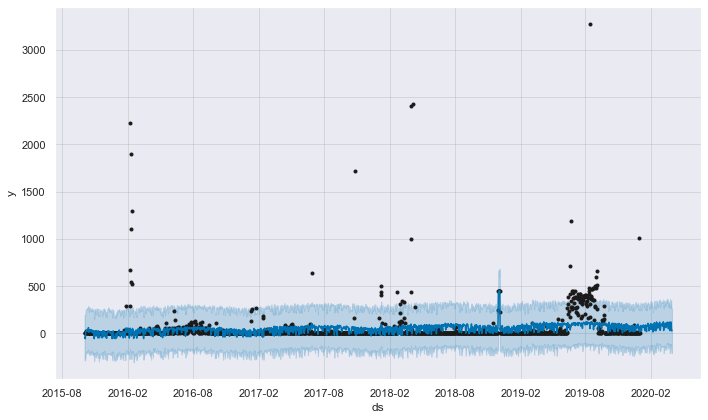

In [102]:
# Build model with best parameters
prophet = Prophet(weekly_seasonality=False, yearly_seasonality=False, changepoint_prior_scale=.001, seasonality_prior_scale=.01)
prophet.add_regressor('MMT')
prophet.add_regressor('MAT')
prophet.add_regressor('Max_Diff_Inv1')
prophet.fit(Inverter1.loc[:'2019'])
future = prophet.make_future_dataframe(periods=90, freq='D')
future.set_index('ds',inplace=True)
future['MMT'] = Inverter1['MMT']
future['MAT'] = Inverter1['MAT']
future['Max_Diff_Inv1'] = Inverter1['Max_Diff_Inv1']
future.reset_index(inplace=True)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)


In [103]:
print('RMSE:', np.sqrt(mean_squared_error(Inverter1['Diff_Inv1'].loc['2020'], \
                                            forecast['yhat'].iloc[-366:])))
print('MSE:', mean_absolute_error(Inverter1['Diff_Inv1'].loc['2020'], \
                                          forecast['yhat'].iloc[-366:]))

RMSE: 391.29022118436654
MSE: 158.26632507552398


We can see that this controls the trend much better.  Intrestingly, the RMSE is not all that different, but the MSE is significantly lower.  

### Inverter 2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


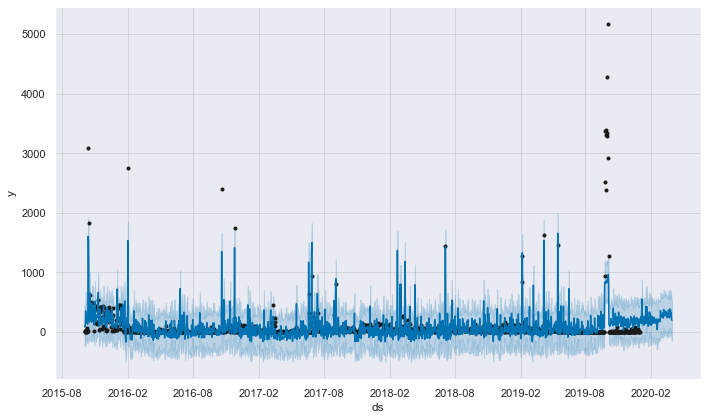

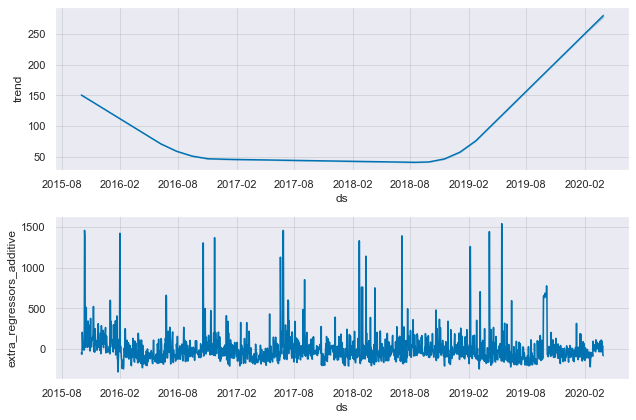

In [104]:
Inverter2['y'] = Inverter2['Diff_Inv2']
Inverter2['ds'] = Inverter2.index

prophet = Prophet(weekly_seasonality=False, yearly_seasonality=False)
prophet.add_regressor('MMT')
prophet.add_regressor('MAT')
prophet.add_regressor('Max_Diff_Inv2')
prophet.fit(Inverter2.loc[:'2019'])
future = prophet.make_future_dataframe(periods=90, freq='D')
future.set_index('ds',inplace=True)
future['MMT'] = Inverter2['MMT']
future['MAT'] = Inverter2['MAT']
future['Max_Diff_Inv2'] = Inverter2['Max_Diff_Inv2']
future.reset_index(inplace=True)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
fig2 = prophet.plot_components(forecast)

In [105]:
print('RMSE:', np.sqrt(mean_squared_error(Inverter1['Diff_Inv1'].loc['2020'], \
                                            forecast['yhat'].iloc[-366:])))
print('MSE:', mean_absolute_error(Inverter1['Diff_Inv1'].loc['2020'], \
                                          forecast['yhat'].iloc[-366:]))

RMSE: 461.95636300053144
MSE: 251.767510866903


In [90]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality': [False],
    'weekly_seasonality': [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    prophet = Prophet(**params).fit(Inverter2.loc[:'2019'])  # Fit model with given params
    df_cv = cross_validation(prophet, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2017-04-15 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1256f8400>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2017-04-15 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x124709400>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2017-04-15 00:00:00 and 2019-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.P

    changepoint_prior_scale  seasonality_prior_scale  yearly_seasonality  \
0                     0.001                     0.01               False   
1                     0.001                     0.10               False   
2                     0.001                     1.00               False   
3                     0.001                    10.00               False   
4                     0.010                     0.01               False   
5                     0.010                     0.10               False   
6                     0.010                     1.00               False   
7                     0.010                    10.00               False   
8                     0.100                     0.01               False   
9                     0.100                     0.10               False   
10                    0.100                     1.00               False   
11                    0.100                    10.00               False   
12          

In [91]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'yearly_seasonality': False, 'weekly_seasonality': False}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


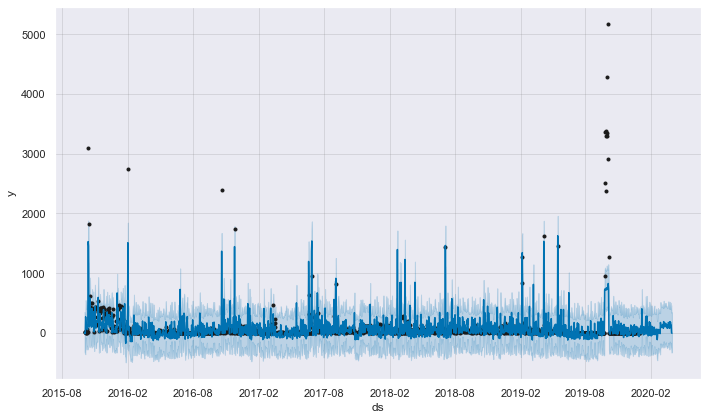

In [106]:
# Build model with best parameters
prophet = Prophet(weekly_seasonality=False, yearly_seasonality=False, changepoint_prior_scale=.001, seasonality_prior_scale=.01)
prophet.add_regressor('MMT')
prophet.add_regressor('MAT')
prophet.add_regressor('Max_Diff_Inv2')
prophet.fit(Inverter2.loc[:'2019'])
future = prophet.make_future_dataframe(periods=90, freq='D')
future.set_index('ds',inplace=True)
future['MMT'] = Inverter1['MMT']
future['MAT'] = Inverter1['MAT']
future['Max_Diff_Inv2'] = Inverter2['Max_Diff_Inv2']
future.reset_index(inplace=True)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)


In [107]:
print('RMSE:', np.sqrt(mean_squared_error(Inverter1['Diff_Inv1'].loc['2020'], \
                                            forecast['yhat'].iloc[-366:])))
print('MSE:', mean_absolute_error(Inverter1['Diff_Inv1'].loc['2020'], \
                                          forecast['yhat'].iloc[-366:]))

RMSE: 453.4954845171372
MSE: 208.1359317776178


We see again that hyperparameter tuning led to a slight decreased in RMSE but a significant decrease in MAE.  